In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas import Series, DataFrame, read_csv
from scipy.integrate import solve_ivp

In [2]:
%matplotlib notebook

In [3]:
g = 9.8 # m / s2
R = 8.314 # J / mol K

In [4]:
substance_data = read_csv("res/substance_data.csv").set_index("Name")

def _as_substance_series(a, **kwargs):
    return Series(a, index=substance_data.index, **kwargs)

In [5]:
reaction_data = read_csv("res/reaction_data_galan.csv").set_index("Reaction")

def _convert(df, src, dst, factor):
    _df = df
    if src in df.columns:
        _df[dst] = _df[src] * factor
    return _df

reaction_data = _convert(reaction_data, "A(Lmol-1s-1)", "A", 1)
reaction_data = _convert(reaction_data, "Ainv(Lmol-1s-1)", "Ainv", 1)
reaction_data = _convert(reaction_data, "Ea(cal/mol)", "Ea", 4.184)
reaction_data = _convert(reaction_data, "Eainv(cal/mol)", "Eainv", 4.184)

_Hf = substance_data["Hf(J/mol)"]

def _hstd(r, p):
    return np.sum([v * H for v, H in p]) - np.sum([v * H for v, H in r])

reaction_data.loc[1, "Hstd"] = _hstd(
    [(1, _Hf["Glycerol"]), (1, _Hf["Acetic Acid"])],
    [(1, _Hf["Monoacetin"]), (1, _Hf["Water"])]
)

reaction_data.loc[2, "Hstd"] = _hstd(
    [(1, _Hf["Monoacetin"]), (1, _Hf["Acetic Acid"])],
    [(1, _Hf["Diacetin"]), (1, _Hf["Water"])]
)

reaction_data.loc[3, "Hstd"] = _hstd(
    [(1, _Hf["Diacetin"]), (1, _Hf["Acetic Acid"])],
    [(1, _Hf["Triacetin"]), (1, _Hf["Water"])]
)

def _as_reaction_series(a, **kwargs):
    return Series(a, index=reaction_data.index, **kwargs)

reaction_data

,A(Lmol-1s-1),Ea(cal/mol),Ainv(Lmol-1s-1),Eainv(cal/mol),A,Ainv,Ea,Eainv,Hstd
Reaction,,,,,,,,,
1,0.000524,616.8,0.000856,-3864.4,0.000524,0.000856,2580.6912,-16168.6496,-36240.0
2,0.000097,-1462.3,216.000000,8701.1,0.000097,216.000000,-6118.2632,36405.4024,-19480.0
3,0.062600,4964.1,1.860000,5137.5,0.062600,1.860000,20769.7944,21495.3000,-12410.0


In [6]:
reaction_rate_table = _as_reaction_series(None, dtype="object")

def _arrhenius(A, Ea, T):
    return A * np.exp(-Ea / (R * T))


def _create_reaction_rate_function(j, l):
    def _f(C, T):
        s = _as_substance_series(C)
        
        A = reaction_data.loc[j, "A"]
        Ea = reaction_data.loc[j, "Ea"]
        k = _arrhenius(A, Ea, T)
        
        Ainv = reaction_data.loc[j, "Ainv"]
        Eainv = reaction_data.loc[j, "Eainv"]
        kinv = _arrhenius(Ainv, Eainv, T)
        
        a, b, c, d = (s[l[i]] for i in range(0, 4))
        
        return -k * a * b + kinv * c * d
    return _f
    

reaction_rate_table[1] = _create_reaction_rate_function(
    1, ["Glycerol", "Acetic Acid", "Monoacetin", "Water"]
)

reaction_rate_table[2] = _create_reaction_rate_function(
    2, ["Monoacetin", "Acetic Acid", "Diacetin", "Water"]
)

reaction_rate_table[3] = _create_reaction_rate_function(
    3, ["Diacetin", "Acetic Acid", "Triacetin", "Water"]
)

reaction_rate_table

Reaction
1    <function _create_reaction_rate_function.<loca...
2    <function _create_reaction_rate_function.<loca...
3    <function _create_reaction_rate_function.<loca...
dtype: object

In [7]:
net_reaction_rate_table = _as_substance_series(None, dtype="object")

def _create_net_reaction_rate_function(f):
    def _f(C, T, r=reaction_rate_table):
        return f(C, T, r)
    return _f

net_reaction_rate_table["Glycerol"] = _create_net_reaction_rate_function(
    lambda C, T, r: r[1](C, T) 
)

net_reaction_rate_table["Acetic Acid"] = _create_net_reaction_rate_function(
    lambda C, T, r: r[1](C, T) + r[2](C, T) + r[3](C, T)
)

net_reaction_rate_table["Water"] = _create_net_reaction_rate_function(
    lambda C, T, r: -r[1](C, T) - r[2](C, T) - r[3](C, T)
)

net_reaction_rate_table["Triacetin"] = _create_net_reaction_rate_function(
    lambda C, T, r: -r[3](C, T)
)

net_reaction_rate_table["Diacetin"] = _create_net_reaction_rate_function(
    lambda C, T, r: -r[2](C, T) + r[3](C, T)
)

net_reaction_rate_table["Monoacetin"] = _create_net_reaction_rate_function(
    lambda C, T, r: -r[1](C, T) + r[2](C, T)
)

net_reaction_rate_table

Name
Glycerol       <function _create_net_reaction_rate_function.<...
Acetic Acid    <function _create_net_reaction_rate_function.<...
Water          <function _create_net_reaction_rate_function.<...
Triacetin      <function _create_net_reaction_rate_function.<...
Diacetin       <function _create_net_reaction_rate_function.<...
Monoacetin     <function _create_net_reaction_rate_function.<...
dtype: object

In [8]:
def _as_substance_series(a):
    return Series(a, index=substance_data.index)


def _as_reaction_series(a):
    return Series(a, index=reaction_data.index)


def evaluate_reaction_rates(C, T):
    # C: (L/mol), T: (K), return: (mol/Ls)
     return _as_reaction_series([r(C, T) for r in reaction_rate_table])


def evaluate_net_reaction_rates(C, T):
    # C: (L/mol), T: (K), return: (mol/Ls)
    return _as_substance_series([r(C, T) for r in net_reaction_rate_table])


def evaluate_temperature_rate(v, F, T, Ta, D, U):
    # v: (L/s), F: (mol/s), T: (K), Ta: (K), D: (m),  U: (W/m2K), return: (K/m)
    _U = U / 100 # W/dm2K
    _D = D * 10 # dm
    At = np.pi * _D * _D / 4 # dm2
    r = evaluate_reaction_rates(F / v, T)
    
    # this works because the acetic acid has v=-1 in all reactions
    _1 = _U * 4 / _D * (Ta - T)
    _2 = np.sum([-rij * -Hrxnij for rij, Hrxnij in zip(r, reaction_data["Hstd"])])
    _3 = np.sum([Fi * Cpi for Fi, Cpi in zip(F, substance_data["Cp(J/molK)"])])
    
    return (_1 + _2) / _3 * At


def _as_objective_function_series(parameters):
    index = substance_data.index.union(["T"], sort=False)
    return Series(parameters, index=index)


def _unpack_objective_function_vector(vector):
    s = _as_objective_function_series(vector)
    return s.loc(axis=0)[substance_data.index], s["T"]


def _create_objective_function(v0, F0, Ta, D, U):
    def objective_function(L, vector):
        F, T = _unpack_objective_function_vector(vector)
        _r = evaluate_net_reaction_rates(F / v0, T)
        _T = evaluate_temperature_rate(v0, F, T, Ta, D, U)
        return np.concatenate((_r, [_T]))
    return objective_function


def _estimate_density(F):
    return np.average(substance_data["p(kg/m3)"])


def _bernoulli_pressure_drop(F, L):
    p = _estimate_density(F)
    return p * g * L * 9.86923e-6


def _estimate_volumetric_flow(F):
    s = _as_substance_series(F) # mol / s
    w = substance_data["MW(g/mol)"] * s / 1000 # kg / mol
    return np.sum(w / substance_data["p(kg/m3)"]) * 1000 # L / s


def solve(**kwargs):
    F0 = kwargs.pop("F0") # mol / s
    T0 = kwargs.pop("T0") # K
    P0 = kwargs.pop("P0") # atm
    Ta = kwargs.pop("Ta") # K
    D = kwargs.pop("D") # m
    U = kwargs.pop("U") # U
    L = kwargs.pop("L") # m
    v0 = _estimate_volumetric_flow(F0) # L / s
    
    # create the objective function
    _f = _create_objective_function(v0, F0, Ta, D, U)
    
    _L = L * 10 # dm
    
    # solve with RK45
    r = solve_ivp(_f, [0, _L], np.concatenate((F0, [T0])), **kwargs)
    
    # create the dataframe
    columns = substance_data.index.union(["T"], sort=False).to_numpy()
    df = DataFrame(r.y.transpose(), index=r.t / 10, columns=columns)
    
    # calculate the pressure
    df["P"] = P0 - np.vectorize(lambda L: _bernoulli_pressure_drop(F0, L))(df.index) 
    
    return df

In [90]:
solution = solve(
    F0 = [0.1, 1.6, 0, 0, 0, 0], # mol / s
    T0 = 400, # K
    P0 = 10, # atm
    Ta = 298.15, # K
    D = 1 * 2.54 / 100, # m
    U = 5, # W / m2 C
    L = 20, # m
    max_step=1
)

In [91]:
solution

,Glycerol,Acetic Acid,Water,Triacetin,Diacetin,Monoacetin,T,P
0.000000,0.100000,1.600000,0.000000,0.000000e+00,0.000000,0.000000,400.000000,10.000000
0.008611,0.099660,1.599659,0.000341,8.328829e-10,0.000001,0.000338,400.000991,9.999051
0.094720,0.096378,1.596209,0.003791,1.063376e-06,0.000167,0.003454,400.010687,9.989560
0.194720,0.092987,1.592316,0.007684,8.729789e-06,0.000653,0.006351,400.020250,9.978537
0.294720,0.090198,1.588772,0.011228,2.838413e-05,0.001370,0.008404,400.026714,9.967515
...,...,...,...,...,...,...,...,...
19.694720,0.070864,1.532604,0.067396,1.250767e-02,0.013245,0.003384,397.449797,7.829187
19.794720,0.070861,1.532595,0.067405,1.250991e-02,0.013246,0.003383,397.435480,7.818165
19.894720,0.070859,1.532587,0.067413,1.251210e-02,0.013247,0.003382,397.421165,7.807142
19.994720,0.070856,1.532579,0.067421,1.251424e-02,0.013249,0.003381,397.406850,7.796120


<IPython.core.display.Javascript object>


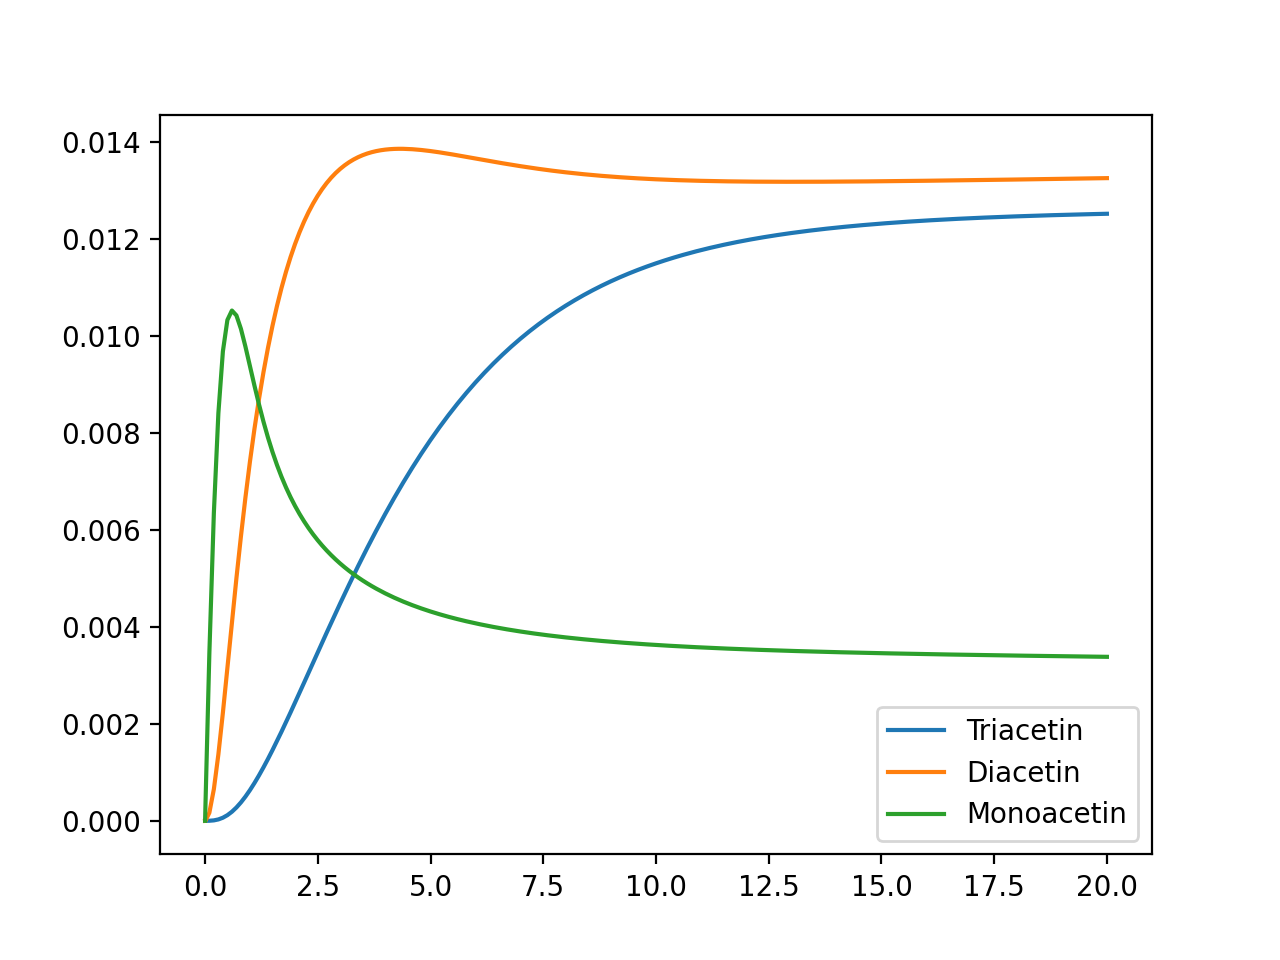

<AxesSubplot: >

In [92]:
molar_flows = solution[["Triacetin", "Diacetin", "Monoacetin"]]
molar_flows.plot()

In [93]:
molar_flows["Triacetin"].to_numpy()[-1] * substance_data.loc["Triacetin", "MW(g/mol)"] / 1000 * 3600

9.830452826793751